In [228]:
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba.typed import List
import time
from numba.typed import Dict
from numba.core import types
import numba

In [291]:

@jit(nopython=True)
def combinations(node_list):
    comb_list=List.empty_list(types.int32)
    for  indx,i in enumerate(node_list):
        for j in node_list[indx+1:]:
            comb_list.append(j)
            comb_list.append(i)
            
    return comb_list

In [292]:
@jit(nopython=True)
def initialize_graph(n_list: numba.typed.typedlist.List, gr_dict: numba.typed.typeddict.Dict ,gr_list: numba.typed.typedlist.List, num_initial_nodes: int):
    """
    Create inital regular graph with num_initial_nodes nodes, one group and aa inter group connections.

    Parameters:   n_list: list of nodes of the graph. This list represents nodes and their connections in the following convention => 
    
    [|con_node1, con_node2,.....,con_nodeAA,con_nodeAA+1, con_nodeAA+2,.....,con_nodeBB,(aa+bb)*obs_node||....|]
    
    for example for node 2 connected with nodes 1 and 0 and node 3 connected with 2 and 0
    
    [|1,0,2,2|,|2,0,3,3|]

    gr_dict: dictionary containing group of every node.
    
    gr_list: list of lists containg the information about the contents and degree of nodes in subgroup.
    
    Each sublist keeps the as many observations of node grom this specific group as many connections this node has to other nodes.
    
    From the previous example if 0 1 and 2 are from group 0 and 3 is from group 1
    
    [[0,0,1,2,2,2],[3,3]]
    
    num_initial_nodes: initial number of nodes in graph.

    """
    #create initial regular graph
    for ii in np.arange(num_initial_nodes):
        gr_dict[ii]=0
    
    for val in combinations(np.arange(num_initial_nodes)):
        n_list.append(val)
    
    #create group zero with initial nodes
    gr_list.append(n_list.copy())
    

In [293]:
@jit(nopython=True)
def add_global_connections(n_list: numba.typed.typedlist.List, gr_dict: numba.typed.typeddict.Dict ,gr_list: numba.typed.typedlist.List, bb: int, new_node_id :int, new_node_group_id :int, initial_length: int):
    """
    Add global connections to the newly created node.

    Parameters:   n_list: list of nodes of the graph. This list represents nodes and their connections in the following convention => 
    
    [|con_node1, con_node2,.....,con_nodeAA,con_nodeAA+1, con_nodeAA+2,.....,con_nodeBB,(aa+bb)*obs_node||....|]
    
    for example for node 2 connected with nodes 1 and 0 and node 3 connected with 2 and 0
    
    [|1,0,2,2|,|2,0,3,3|]

    gr_dict: dictionary containing group of every node.
    
    gr_list: list of lists containg the information about the contents and degree of nodes in subgroups.
    
    Each sublist keeps the as many observations of node grom this specific group as many connections this node has to other nodes.
    
    From the previous example if 0 1 and 2 are from group 0 and 3 is from group 1
    
    [[0,0,1,2,2,2],[3,3]]
    
    bb: number of global connections created by this new node.
    
    new_node_id: ID of the added node for which we are creating connections.
    
    new_node_group_id: ID of group of the added node for which we are creating connections.
    
    initial_length: Length of the node vector in the end of previous step, we are adding nodes in bunches always looking at the previous network landscape

    """
    indexes=List()
    
    for ii in np.arange(0,bb):
        ind=np.random.randint(0,initial_length)
        indexes.append(ind)

        #append selected connections to the list 
    for indx in indexes:
        node_id=n_list[indx]
        n_list.append(node_id)
        gr_list[gr_dict[node_id]].append(node_id)
        n_list.append(new_node_id)
        gr_list[new_node_group_id].append(new_node_id)



In [294]:
@jit(nopython=True)
def add_new_group_connections(n_list: numba.typed.typedlist.List ,gr_list: numba.typed.typedlist.List, aa: int, new_node_id: int, new_group_id: int, initial_group_length: int):
    """
    Add connections to the newly created node in the newly created group obtained by adding bunch of new nodes to the graph.

    Parameters:   n_list: list of nodes of the graph. This list represents nodes and their connections in the following convention => 
    
    [|con_node1, con_node2,.....,con_nodeAA,con_nodeAA+1, con_nodeAA+2,.....,con_nodeBB,(aa+bb)*obs_node||....|]
    
    for example for node 2 connected with nodes 1 and 0 and node 3 connected with 2 and 0
    
    [|1,0,2,2|,|2,0,3,3|]
    
    gr_list: list of lists containg the information about the contents and degree of nodes in subgroups.
    
    Each sublist keeps the as many observations of node grom this specific group as many connections this node has to other nodes.
    
    From the previous example if 0 1 and 2 are from group 0 and 3 is from group 1
    
    [[0,0,1,2,2,2],[3,3]]
    
    aa: number of in group connections created by this new node.
    
    new_node_id: ID of the added node for which we are creating connections.
    
    new_group_id: ID of group of the added node for which we are creating connections.
    
    initial_group_length: Length of the new_group list in the end of previous step, we are adding nodes in bunches always looking at the previous network landscape

    """
    indexes=List()

    #proportional attachment of a connections inside newly created group
    for ii in np.arange(0,aa):
        ind=np.random.randint(0,initial_group_length)
        indexes.append(ind)
        
    #append created connections to the list
    for indx in indexes:
        node_id=gr_list[new_group_id][indx]
        n_list.append(node_id)
        gr_list[new_group_id].append(node_id)
        gr_list[new_group_id].append(new_node_id)
        n_list.append(new_node_id)
        


In [384]:
@jit(nopython=True)
def add_old_group_connections(n_list: numba.typed.typedlist.List, gr_dict: numba.typed.typeddict.Dict ,gr_list: numba.typed.typedlist.List, aa: int, new_node_id: int, initial_length: int):
    """
    Add connections to the newly created node in the preselected preexisting group.

    Parameters:   n_list: list of nodes of the graph. This list represents nodes and their connections in the following convention => 
    
    [|con_node1, con_node2,.....,con_nodeAA,con_nodeAA+1, con_nodeAA+2,.....,con_nodeBB,(aa+bb)*obs_node||....|]
    
    for example for node 2 connected with nodes 1 and 0 and node 3 connected with 2 and 0
    
    [|1,0,2,2|,|2,0,3,3|]
    
    gr_dict: dictionary containing group of every node.
    
    gr_list: list of lists containg the information about the contents and degree of nodes in subgroups.
    
    Each sublist keeps the as many observations of node grom this specific group as many connections this node has to other nodes.
    
    From the previous example if 0 1 and 2 are from group 0 and 3 is from group 1
    
    [[0,0,1,2,2,2],[3,3]]
    
    aa: number of in group connections created by this new node.
    
    new_node_id: ID of the added node for which we are creating connections.
    
    initial_length: Length of the node vector in the end of previous step, we are adding nodes in bunches always looking at the previous network landscape

    """   
    indexes=List()
    
    #initial node to which our new node will attach, selected from all of the nodes with the preference
    initial_index=np.random.randint(0,initial_length)
    group_id=gr_dict[n_list[initial_index]]
    
    #attach the new node to the same group as the group of the initial node
    gr_dict[new_node_id]=group_id
    
    #select more nodes from selected group
    for ii in np.arange(0,aa-1):
        # ind=np.random.randint(0,init_gr_len[group_id])
        ind=np.random.randint(0,len(gr_list[group_id]))
        indexes.append(ind)
    
    #append initial connection to the list
    n_list.append(n_list[initial_index])
    n_list.append(new_node_id)
    gr_list[group_id].append(n_list[initial_index])
    gr_list[group_id].append(new_node_id)
    
    #append created connections to the lists
    for indx in indexes:
        node_id=gr_list[group_id][indx]
        n_list.append(node_id)
        gr_list[group_id].append(node_id)
        n_list.append(new_node_id)
        gr_list[group_id].append(new_node_id)
    
        


In [492]:
@jit(nopython=True)
def proportional_attach(node_list: numba.typed.typedlist.List, group_dict: numba.typed.typeddict.Dict ,groups: numba.typed.typedlist.List, mm: int,aa: int,bb: int,pp: float):
    """
    Build complex evolving graph using set of rules expanded upon in README.

    Parameters:   node_list: list of nodes of the graph. This list represents nodes and their connections in the following convention => 
    
    [|con_node1, con_node2,.....,con_nodeAA,con_nodeAA+1, con_nodeAA+2,.....,con_nodeBB,(aa+bb)*obs_node||....|]
    
    for example for node 2 connected with nodes 1 and 0 and node 3 connected with 2 and 0
    
    [|1,0,2,2|,|2,0,3,3|]
    
    group_dict: dictionary containing group of every node.
    
    groups: list of lists containg the information about the contents and degree of nodes in subgroups.
    
    Each sublist keeps the as many observations of node grom this specific group as many connections this node has to other nodes.
    
    From the previous example if 0 1 and 2 are from group 0 and 3 is from group 1
    
    [[0,0,1,2,2,2],[3,3]]
    
    mm: number of nodes added in each step.
    
    aa: number of in group connections created by the new node.
    
    bb: number of global connections created by the new node.
    
    pp: probability that newly added nodes will create a new group.

    """ 
    #initial length of an node_list, lets us get proportial attachment on the basis of the old list for each of the new added nodes
    length_init=len(node_list)-1
    #until you reach number of nodes which should be added

    #decide whether we want to append this point to existing group or create new group
    if np.random.random()<pp:
        # print("hello1")

        #create new group for new nodes
        groups.append(List.empty_list(types.int32))
        new_group_id=len(groups)-1
        created_nodes=List.empty_list(types.int32)
        for node in np.arange(mm):
            # indexes=List()
            #number of added node
            added_node=len(group_dict)
            created_nodes.append(added_node)
            group_dict[added_node]=new_group_id
            
            add_global_connections(node_list,group_dict,groups,bb,added_node,new_group_id,length_init)
            
        
        #create connections inside group, we create full graph from all of the nodes
        for node_id in combinations(created_nodes):
            node_list.append(node_id)
            groups[new_group_id].append(node_id)
        
        # group_size_dict[new_group_id]=len(groups[new_group_id])
        # for added_node in created_nodes:
        #     add_new_group_connections(node_list, groups, aa, added_node, new_group_id, init_group_length)
    else:
            # print("hello2")
            created_nodes=List.empty_list(types.int32)
            #needs checking
            # init_group_length=[len(subgroup)-1 for subgroup in groups]
            for node in np.arange(mm):
                
                #number of added node
                added_node=len(group_dict)
                created_nodes.append(added_node)
                
                add_old_group_connections(node_list,group_dict, groups, aa, added_node, length_init)
                
            for added_node in created_nodes:
                add_global_connections(node_list,group_dict,groups,bb,added_node,group_dict[added_node],length_init)
                    



In [495]:
initial_nodes=4
# n_nodes=10**8
n_nodes=10**6
# n_nodes=10

#parameters
a=2
b=1

node_list=List.empty_list(types.int32)

group_dict = Dict.empty(
    key_type=types.int64,
    value_type=types.int64,
)

group_size_dict = Dict.empty(
key_type=types.int64,
value_type=types.int64,
)

groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))

initialize_graph(node_list, group_dict, groups, initial_nodes)

In [496]:
m=a+1
p=1

for n_number in tqdm(np.arange(initial_nodes,n_nodes+initial_nodes,m)):
    proportional_attach(node_list,group_dict,groups,m,a,b,p)

100%|██████████| 333334/333334 [00:05<00:00, 59701.76it/s]


Text(0.5, 1.0, 'Wykres dla m=3, $\\gamma$=-3.67, p=1')

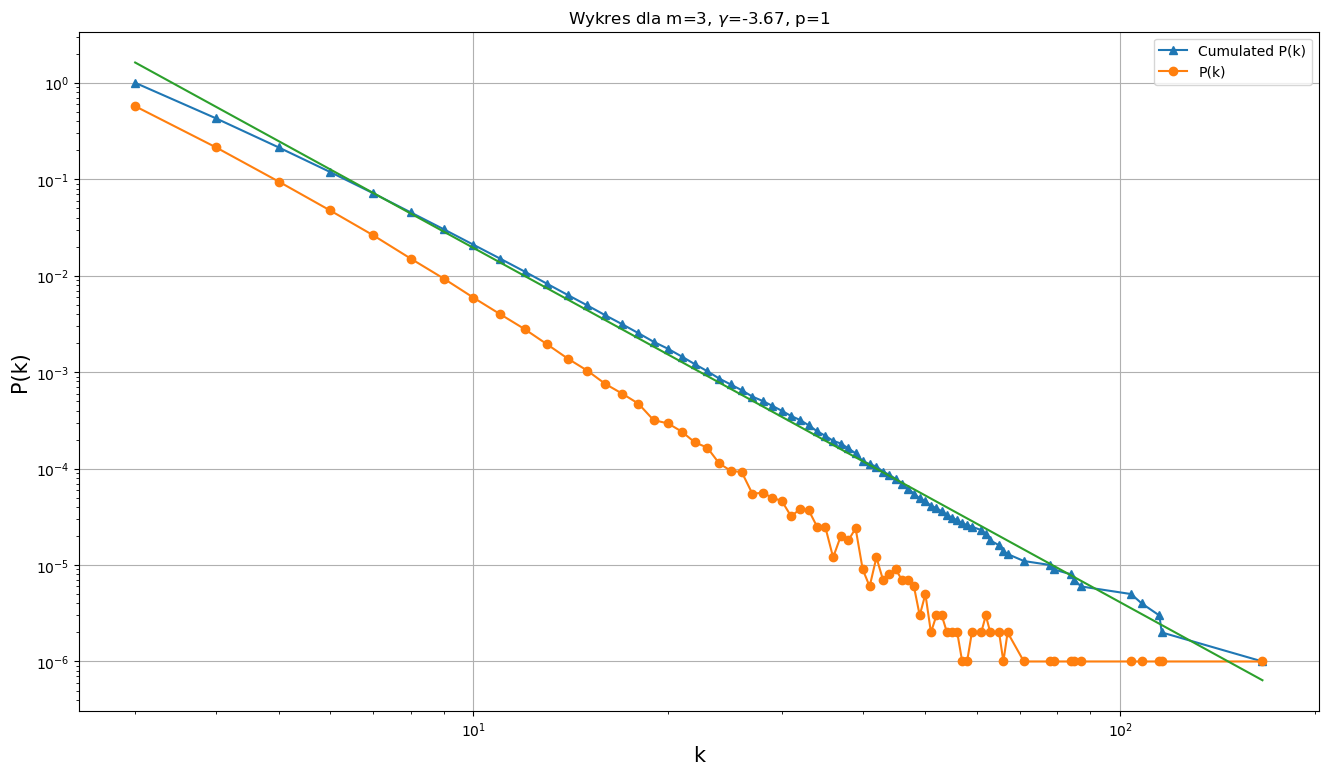

In [497]:
vals,counts=np.unique(node_list,return_counts=True)
vals,counts=np.unique(counts,return_counts=True)

prob=counts/np.sum(counts)
cum_sum=np.cumsum(prob[::-1])[::-1]


plt.figure(figsize=(16,9),dpi= 100)
plt.loglog(vals,cum_sum,"^-",label="Cumulated P(k)")

logx = np.log(vals)
logy = np.log(cum_sum)
coeffs = np.polyfit(logx,logy,deg=1)
poly = np.poly1d(coeffs)
yfit = lambda x: np.exp(poly(np.log(x)))
plt.loglog(vals,prob,"o-",label="P(k)")
plt.loglog(vals,yfit(vals))
plt.legend()
plt.grid()
plt.xlabel("k",fontsize=15)
plt.ylabel("P(k)",fontsize=15)
plt.title(f"Wykres dla m={m}, $\gamma$={np.round(coeffs[0],2)}, p={p}")

Text(0.5, 1.0, 'Rozkład rozmiarów grup. Wykres dla m=3, $\\gamma$=-3.78, p=1')

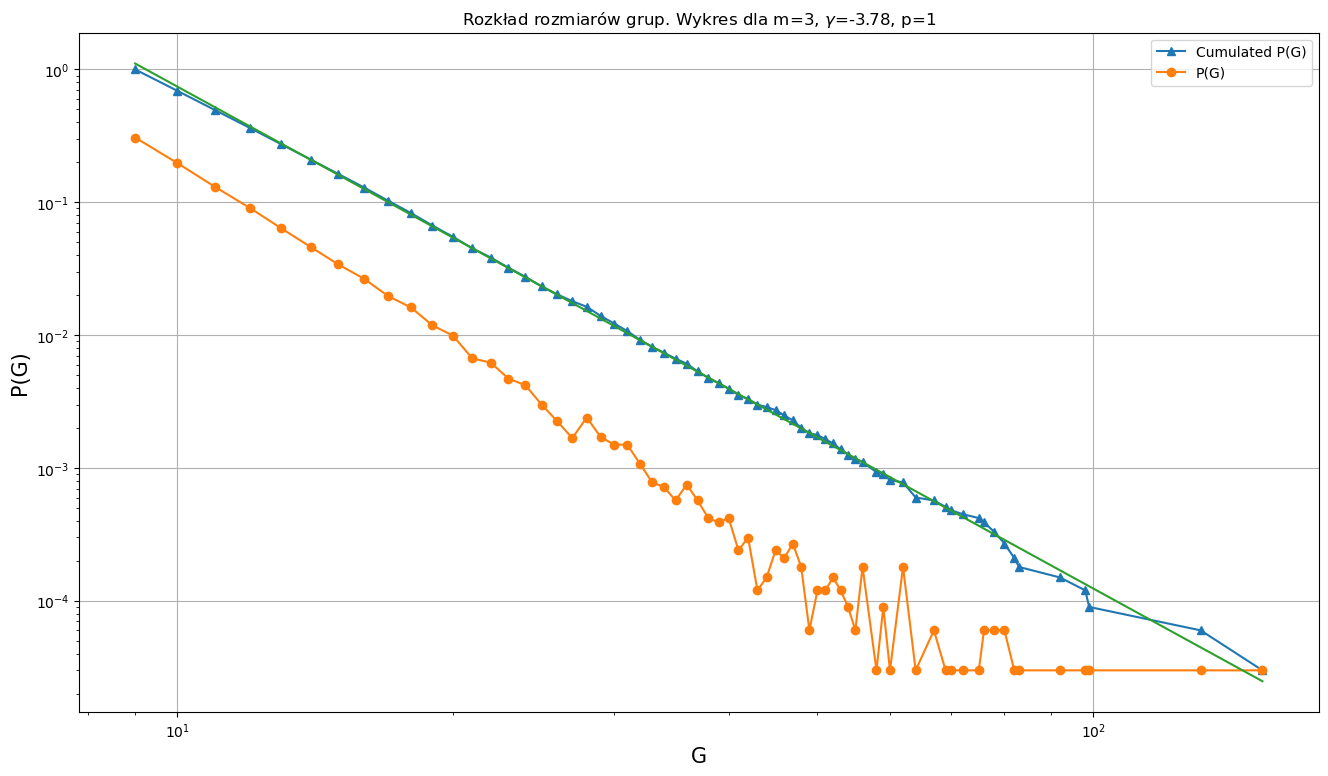

In [ ]:
group_size_list=[len(subgroup) for subgroup in groups]
vals,counts=np.unique(group_size_list,return_counts=True)
# vals,counts=np.unique(counts,return_counts=True)
prob=counts/np.sum(counts)
cum_sum=np.cumsum(prob[::-1])[::-1]


plt.figure(figsize=(16,9),dpi= 100)
plt.loglog(vals,cum_sum,"^-",label="Cumulated P(G)")

logx = np.log(vals)
logy = np.log(cum_sum)
coeffs = np.polyfit(logx,logy,deg=1)
poly = np.poly1d(coeffs)
yfit = lambda x: np.exp(poly(np.log(x)))
plt.loglog(vals,prob,"o-",label="P(G)")
plt.loglog(vals,yfit(vals))
plt.legend()
plt.grid()
plt.xlabel("G",fontsize=15)
plt.ylabel("P(G)",fontsize=15)
plt.title(f"Rozkład rozmiarów grup. Wykres dla m={m}, $\gamma$={np.round(coeffs[0],2)}, p={p}")

In [498]:
#saving output to the file !!!!!!!!!!!!!!!!!!!
for a in tqdm(np.array([2,4,6])):
    initial_nodes=4
    n_nodes=10**5

    #parameters
    b=1
    p=0.2
    m=a+1
    node_list=List.empty_list(types.int32)

    group_dict = Dict.empty(
        key_type=types.int64,
        value_type=types.int64,
    )
    groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))

    initialize_graph(node_list, group_dict, groups, initial_nodes)    
    for n_number in tqdm(np.arange(initial_nodes,n_nodes+initial_nodes,m)):
        proportional_attach(node_list,group_dict,groups,m,a,b,p)
    file_name=f'out_graph_p_0{int(10*p)}_a_{a}_b_{b}.txt'
    with open(file_name, 'a') as data:
        # for node_1, node_2 in zip(node_list,node_list[::2]): 
        for ii in range(0,len(node_list),2):
            # data.write(f'{node_1}\t{node_2}\n')
            data.write(f'{node_list[ii]}\t{node_list[ii+1]}\n')

100%|██████████| 3/3 [00:13<00:00,  4.46s/it]


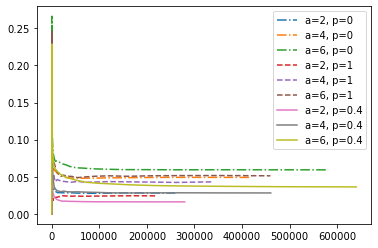

In [499]:

from collections import Counter
from collections import defaultdict
plt.figure()
# file_names=['out_graph_p_00_a_2_b_1.txt','out_graph_p_00_a_4_b_1.txt','out_graph_p_00_a_6_b_1.txt','out_graph_p_010_a_2_b_1.txt','out_graph_p_010_a_4_b_1.txt','out_graph_p_010_a_6_b_1.txt','out_graph_p_04_a_2_b_1.txt','out_graph_p_04_a_4_b_1.txt','out_graph_p_04_a_6_b_1.txt']
# file_names=['out_graph_p_00_a_2_b_0.txt','out_graph_p_00_a_4_b_0.txt','out_graph_p_00_a_6_b_0.txt','out_graph_p_010_a_2_b_0.txt','out_graph_p_010_a_4_b_0.txt','out_graph_p_010_a_6_b_0.txt','out_graph_p_04_a_2_b_0.txt','out_graph_p_04_a_4_b_0.txt','out_graph_p_04_a_6_b_0.txt']
file_names=['out_graph_p_04_a_2_b_1.txt','out_graph_p_04_a_4_b_1.txt','out_graph_p_04_a_6_b_1.txt',
            'out_graph_p_08_a_2_b_1.txt','out_graph_p_08_a_4_b_1.txt','out_graph_p_08_a_6_b_1.txt',
            'out_graph_p_02_a_2_b_1.txt','out_graph_p_02_a_4_b_1.txt','out_graph_p_02_a_6_b_1.txt']

# file_names=['out_graph_p_00_a_2_b_1.txt']
for file, a, p in zip(file_names,[2,4,6,2,4,6,2,4,6],[0,0,0,1,1,1,0.4,0.4,0.4]):
    xx = open_file(file)
    ll=[]
    for ii in np.logspace(0,np.log10(len(xx)),50,dtype=int):
        d = defaultdict(lambda : 0)
        for val in xx[:ii]:
            d[val]+=1
        ll.append(d)
    duplicates_num=[]
    for val, size in zip(ll,np.logspace(0,np.log10(len(xx)),50,dtype=float)):
        duplicates_num.append((sum(np.array(list(val.values()))>1))/size)
    if(p==1):
        style='--'
    elif (p==0):
        style='-.'  
    else:
        style='-'
    
    plt.plot(np.logspace(0,np.log10(len(xx)),50,dtype=int), duplicates_num,label=f'a={a}, p={p}',linestyle=style)
plt.legend()

In [258]:
gamma_list=[]
gamma_list_groups=[]
for p in tqdm(np.arange(0,1.02,0.05)):
    initial_nodes=4
    n_nodes=10**5

    #parameters
    b=1
    m=4
    node_list=List.empty_list(types.int32)

    group_dict = Dict.empty(
        key_type=types.int64,
        value_type=types.int64,
    )
    groups=List.empty_list(numba.typeof(List.empty_list(types.int32)))

    initialize_graph(node_list, group_dict, groups, initial_nodes)    
    for n_number in tqdm(np.arange(initial_nodes,n_nodes+initial_nodes,m)):
        proportional_attach(node_list,group_dict,groups,m,a,b,p)
    vals,counts=np.unique(node_list,return_counts=True)
    vals,counts=np.unique(counts,return_counts=True)
    prob=counts/np.sum(counts)
    cum_sum=np.cumsum(prob[::-1])[::-1]
    logx = np.log(vals)
    logy = np.log(cum_sum)
    coeffs = np.polyfit(logx,logy,deg=1)
    gamma_list.append(coeffs[0])
    
    group_size_list=[len(subgroup) for subgroup in groups]
    vals,counts=np.unique(group_size_list,return_counts=True)
    # vals,counts=np.unique(counts,return_counts=True)
    prob=counts/np.sum(counts)
    cum_sum=np.cumsum(prob[::-1])[::-1]

    logx = np.log(vals)
    logy = np.log(cum_sum)
    coeffs = np.polyfit(logx,logy,deg=1)
    gamma_list_groups.append(coeffs[0])

100%|██████████| 25000/25000 [00:00<00:00, 43627.52it/s]
E:\programy\pyton\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 21/21 [01:13<00:00,  3.52s/it]


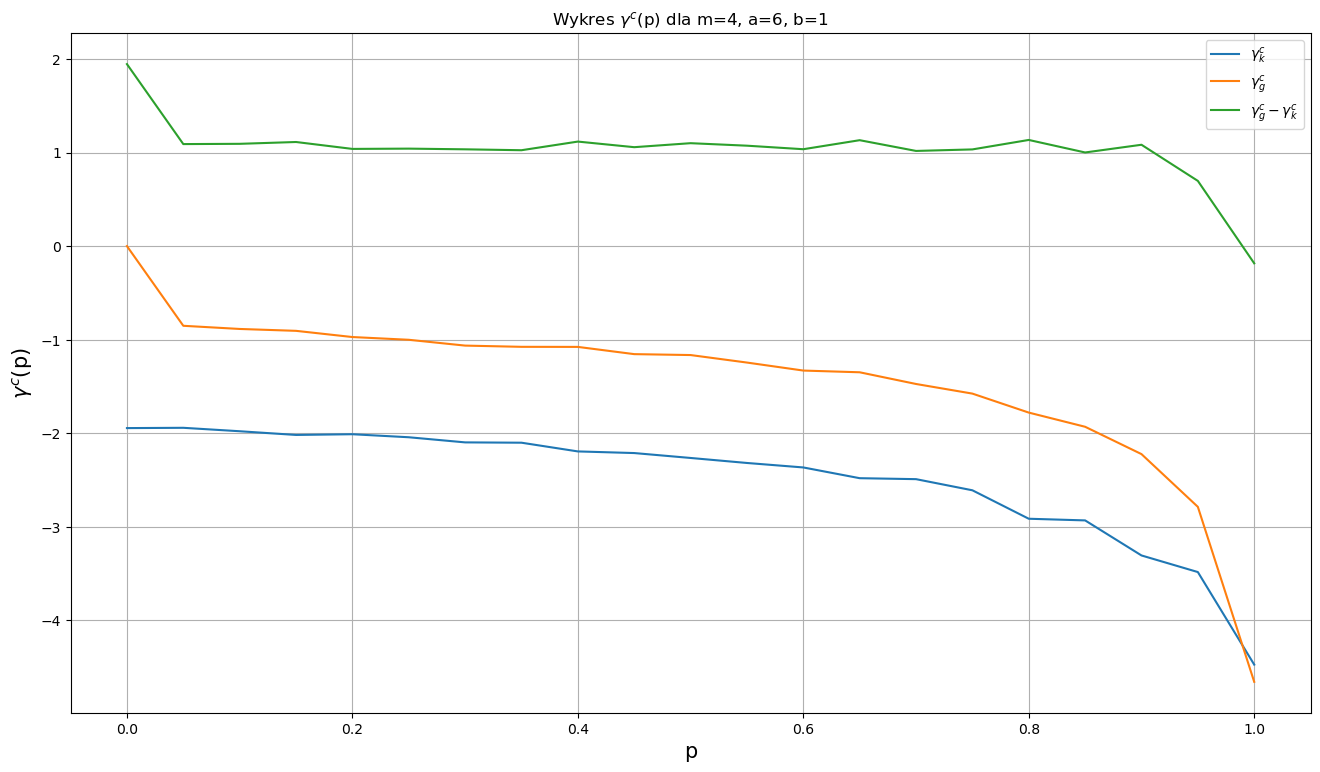

In [268]:
plt.figure(figsize=(16,9),dpi= 100)
plt.plot(np.arange(0,1.02,0.05),gamma_list, label=f'$\gamma_k^c$')
plt.plot(np.arange(0,1.02,0.05),gamma_list_groups,label=f'$\gamma_g^c$')
plt.plot(np.arange(0,1.02,0.05),np.array(gamma_list_groups)-np.array(gamma_list),label=f'$\gamma_g^c-\gamma_k^c$')
plt.grid()
plt.xlabel("p",fontsize=15)
plt.ylabel(f"$\gamma^c$(p)",fontsize=15)
plt.title(f"Wykres $\gamma^c$(p) dla m={m}, a={a}, b={b}")
plt.legend()

In [431]:
#check if node list was saved correctly
def open_file(file_name):
    with open(file_name, 'r') as data:
        xx = []
        yy = []
        for line in data:
            p = line.split()
            xx.append((int(p[0]),int(p[1])))
            

    return (xx)

xx = open_file('out_graph_p_04_a_6_b_1.txt')
# np.unique(xx-node_list)

In [441]:
0.08*len(xx)

46541.520000000004